In [8]:
import json
import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd


def classifier_performance_metrics(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test)
    matrix = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp )
    recall = tp / (tp + fn)
    print({
        "classifier": classifier,
        "tn": tn, 
        "fp": fp, 
        "fn": fn, 
        "tp": tp,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    })
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

X = []
y = []

with open('data/paths-benign.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(0)

with open('data/paths-malicious.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [9]:
from sklearn.neural_network import MLPClassifier

# multi hot bag of bytes encoding
def path_to_vector(path):
    path_bytes = [i for i in bytes(path, 'ascii')]
    vector = [0 for i in range(0x20, 0x7e+1)]
    for i in path_bytes:
        try:
            vector[i - 0x20] = 1
        except Exception as e:
            print(i)
            raise e
    return vector

nn_classifier = MLPClassifier(hidden_layer_sizes=(), random_state=1234)
nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)


MLPClassifier(hidden_layer_sizes=(), random_state=1234)

In [10]:
def render_printable(i):
    i = i + 0x20
    if i > 32 and i < 127:
        r = chr(i)
    else: 
        r = hex(i)
    return r

coefficients = [(render_printable(i), nn_classifier.coefs_[0][i][0]) 
                for i in range(len(nn_classifier.coefs_[0]))]

pprint.pprint(coefficients[:5])


[('0x20', 1.0545668961701062),
 ('!', 9.549914394250365e-53),
 ('"', -1.2644146743918027e-58),
 ('#', 5.244861784185765e-15),
 ('$', 1.7231055635953305e-15)]


0 32 0 0 0x20 1.0545668961701062
1 33 0 1 ! 9.549914394250365e-53
2 34 0 2 " -1.2644146743918027e-58
3 35 0 3 # 5.244861784185765e-15
4 36 0 4 $ 1.7231055635953305e-15
5 37 0 5 % -0.12825475232003283
6 38 0 6 & -2.3153832790350608e-23
7 39 0 7 ' 1.2652229150034104
8 40 0 8 ( 1.0984161345111552
9 41 0 9 ) 1.0573588816007604
10 42 0 10 * 1.033532681130096e-46
11 43 0 11 + -0.0013405563898867886
12 44 0 12 , 0.4209438121919877
13 45 0 13 - 0.38421498858305053
14 46 0 14 . 0.2767109889662589
15 47 0 15 / -0.5955818462041607
16 48 1 0 0 0.4022951437288508
17 49 1 1 1 0.4259540336707067
18 50 1 2 2 0.8146619927225938
19 51 1 3 3 0.8003519663571332
20 52 1 4 4 0.3656192778169898
21 53 1 5 5 0.5429803205376108
22 54 1 6 6 0.5926597743399055
23 55 1 7 7 0.8178377900662291
24 56 1 8 8 0.6868886883072147
25 57 1 9 9 0.45903866052275266
26 58 1 10 : 0.3002294838705716
27 59 1 11 ; 1.019515325689645e-14
28 60 1 12 < -7.180964449963089e-35
29 61 1 13 = 1.022829576638783
30 62 1 14 > 0.42416549209578

<Axes: >

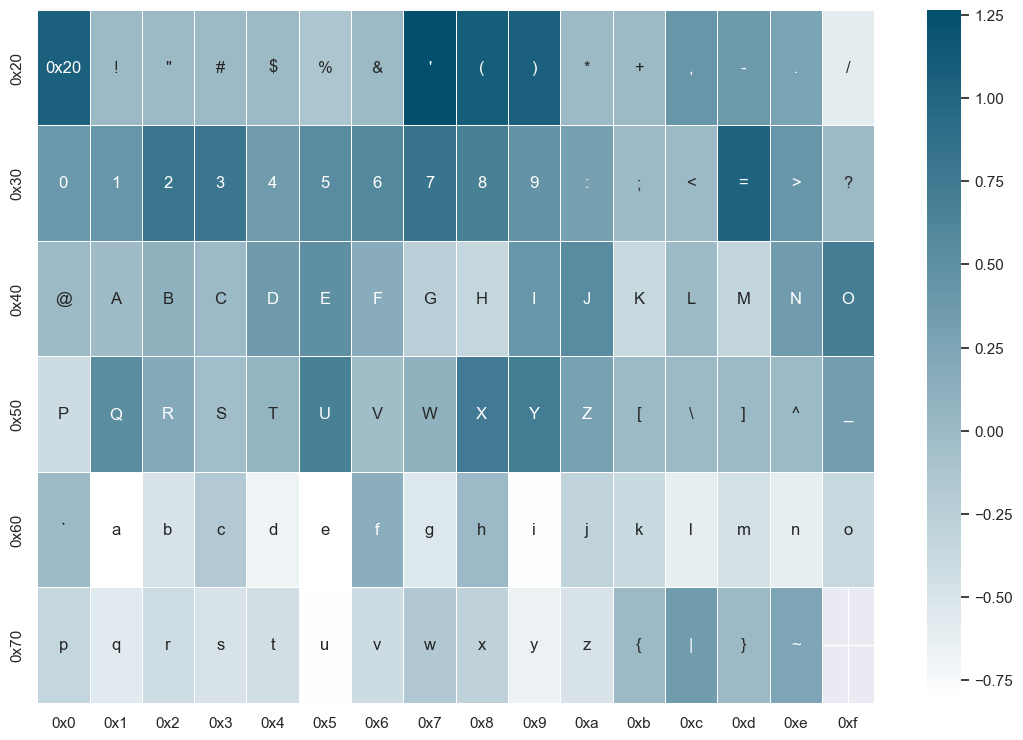

In [11]:

reshaped_keys = [[None for j in range(16)] for i in range(int((len(coefficients)/16)+1))]
reshaped_values = [[None for j in range(16)] for i in range(int((len(coefficients)/16)+1))]
for index in range(0, len(coefficients)):
    character_code = index + 0x20
    i0 = index // 16
    i1 = index % 16
    print(index, character_code, i0, i1, coefficients[index][0], coefficients[index][1])
    reshaped_keys[i0][i1] = coefficients[index][0]
    reshaped_values[i0][i1] = coefficients[index][1]

reshaped_keys = pd.DataFrame(reshaped_keys)
print(reshaped_keys.shape)
reshaped_values = pd.DataFrame(reshaped_values)
print(reshaped_values.shape)

import matplotlib.pyplot as plt
import seaborn as sns
colors = ["#ffffff", "#024f6e"]
sns.set_theme()
my_cmap = sns.blend_palette(colors, as_cmap = True)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(13.5, 9))
sns.heatmap(
    reshaped_values, 
    annot=reshaped_keys, 
    fmt='', 
    linewidths=.5, 
    ax=ax, 
    cmap=my_cmap,
    yticklabels=[hex(i) for i in range(0x20,0x7e+1,16)],
    xticklabels=[hex(i) for i in range(0,16)]
)

In [12]:
sorted_coefficients = sorted(coefficients, key = lambda i: -i[1])
print("Top ten characters: ")
pprint.pprint(sorted_coefficients[:10])
print("Bottom ten characters: ")
pprint.pprint(sorted_coefficients[-10:])

Top ten characters: 
[("'", 1.2652229150034104),
 ('(', 1.0984161345111552),
 (')', 1.0573588816007604),
 ('0x20', 1.0545668961701062),
 ('=', 1.022829576638783),
 ('7', 0.8178377900662291),
 ('2', 0.8146619927225938),
 ('3', 0.8003519663571332),
 ('X', 0.7515530103472962),
 ('Y', 0.7255683767582968)]
Bottom ten characters: 
[('q', -0.5701077197633426),
 ('/', -0.5955818462041607),
 ('n', -0.6154683569342427),
 ('l', -0.6164151075812286),
 ('y', -0.6570195020926318),
 ('d', -0.6718459046422397),
 ('i', -0.7875837504391229),
 ('u', -0.8012446812748186),
 ('e', -0.8164697281578116),
 ('a', -0.8179850763066255)]


{'classifier': MLPClassifier(hidden_layer_sizes=(), random_state=1234), 'tn': 2844, 'fp': 0, 'fn': 4, 'tp': 11, 'accuracy': 0.9986009094088842, 'precision': 1.0, 'recall': 0.7333333333333333}
{'classifier': SpaceClassifier(), 'tn': 2844, 'fp': 0, 'fn': 4, 'tp': 11, 'accuracy': 0.9986009094088842, 'precision': 1.0, 'recall': 0.7333333333333333}
{'classifier': ApostropheClassifier(), 'tn': 2844, 'fp': 0, 'fn': 2, 'tp': 13, 'accuracy': 0.9993004547044421, 'precision': 1.0, 'recall': 0.8666666666666667}
{'classifier': EqualsClassifier(), 'tn': 2844, 'fp': 0, 'fn': 7, 'tp': 8, 'accuracy': 0.9975515914655474, 'precision': 1.0, 'recall': 0.5333333333333333}
{'classifier': RightParenthesisClassifier(), 'tn': 2844, 'fp': 0, 'fn': 6, 'tp': 9, 'accuracy': 0.9979013641133263, 'precision': 1.0, 'recall': 0.6}
{'classifier': LeftParenthesisClassifier(), 'tn': 2844, 'fp': 0, 'fn': 6, 'tp': 9, 'accuracy': 0.9979013641133263, 'precision': 1.0, 'recall': 0.6}


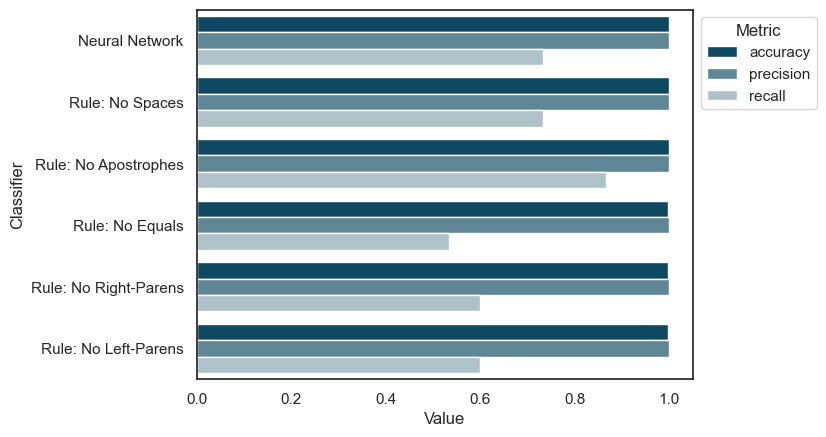

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SpaceClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ' ' in i else 0 for i in X]

class ApostropheClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "'" in i else 0 for i in X]

class EqualsClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "=" in i else 0 for i in X]

class LeftParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "(" in i else 0 for i in X]

class RightParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ")" in i else 0 for i in X]

space_classifier = SpaceClassifier()
apostrophe_classifier = ApostropheClassifier()
equals_classifier = EqualsClassifier()
right_parenthesis_classifier = RightParenthesisClassifier()
left_parenthesis_classifier = LeftParenthesisClassifier()

nn_classifier_performance = classifier_performance_metrics(nn_classifier, [path_to_vector(x) for x in X_test], y_test)
space_classifier_performance = classifier_performance_metrics(space_classifier, X_test, y_test)
apostrophe_classifier_performance = classifier_performance_metrics(apostrophe_classifier, X_test, y_test)
equals_classifier_performance = classifier_performance_metrics(equals_classifier, X_test, y_test)
right_parenthesis_classifier_performance = classifier_performance_metrics(right_parenthesis_classifier, X_test, y_test)
left_parenthesis_classifier_performance = classifier_performance_metrics(left_parenthesis_classifier, X_test, y_test)

import pandas as pd
colors = ["#ffffff", "#024f6e"][::-1]
sns.set_theme(style='white')
palette = sns.blend_palette(colors, n_colors=4)

rows = []
for metric, value in nn_classifier_performance.items():
    rows.append(["Neural Network", metric, value])
for metric, value in space_classifier_performance.items():
    rows.append(["Rule: No Spaces", metric, value])
for metric, value in apostrophe_classifier_performance.items():
    rows.append(["Rule: No Apostrophes", metric, value])
for metric, value in equals_classifier_performance.items():
    rows.append(["Rule: No Equals", metric, value])
for metric, value in right_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Right-Parens", metric, value])
for metric, value in left_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Left-Parens", metric, value])
df = pd.DataFrame(rows, columns=["Classifier", "Metric", "Value"])
df.head()

ax = sns.barplot(
    x="Value", 
    y="Classifier",
    hue='Metric',
    data=df,
    palette=palette
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
